# Figure 5: Annual cycles
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load observations

### Topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

In [4]:
ds = xr.open_dataset('/data/mlalande/Relief/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation_HR = ds.elevation

## ERA-Interim and ERA5
Downloaded from https://cds.climate.copernicus.eu/cdsapp#!/dataset/ecv-for-climate-change?tab=doc (there are correction but doesn't seem to affect HMA)

For Snow Cover Extent, there is only ERA-Interim on the period 1979-2014 and is computed from snow depth (Appendix A : https://tc.copernicus.org/articles/13/2221/2019/) and https://confluence.ecmwf.int/display/CKB/ERA-Interim%3A+documentation#ERAInterim:documentation-Computationofnear-surfacehumidityandsnowcover

In [5]:
path = '/data/mlalande/ERA-ECV/NETCDF'

### ERA-Interim SCF

In [6]:
SD = xr.open_mfdataset('/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/sd.*.asmei.GLOBAL_075.nc').sd.sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)
RW = 1000
obs = xr.ufuncs.minimum(1, RW*SD/15)*100

obs_bin = obs.where(obs < 50, other=100).where(obs >= 50, other=0)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')
obs_ac_bin = u.annual_cycle(obs_bin, calendar='standard')

regridder = xe.Regridder(obs_ac, elevation, 'bilinear', periodic=False, reuse_weights=True)

# Compute annual cycle for each zones
temp = [None]*len(zones)
temp_bin = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
obs_ac_regrid_bin = regridder(obs_ac_bin)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )
    temp_bin[i] = u.spatial_average(
        obs_ac_regrid_bin.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc_erai = xr.concat(temp, pd.Index(zones, name="zone")).load()
obs_ac_regrid_zones_snc_erai_bin = xr.concat(temp_bin, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_47x80_35x60.nc


### ERA5 SCF

In [7]:
# snow water equivalent (ie parameter SD (141.128))
SD = xr.open_mfdataset('/data/mlalande/ERA5/ERA5_monthly_HMA-ext_SD_1979-2014.nc').sd.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)

# RSN is density of snow (parameter 33.128)
RSN = xr.open_dataset('/data/mlalande/ERA5/ERA5_monthly_HMA-ext_RSN_1979-2014.nc').rsn.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=period, lat=slice(latlim_ext.stop, latlim_ext.start), lon=lonlim_ext)

#  RW is density of water equal to 1000
RW = 1000 

# https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Computationofnear-surfacehumidityandsnowcover
obs = xr.ufuncs.minimum(1, (RW*SD/RSN)/0.1) * 100


# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

regridder = xe.Regridder(obs_ac, elevation, 'bilinear', periodic=False, reuse_weights=True)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc_era5 = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_141x241_35x60.nc


### Snow Cover

In [8]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

################################################################
# Try version with all 7 days filled with the monday value (represent the last week value from Tuesday to Monday)
ds = xr.Dataset(
    coords={
        'time': pd.date_range('1979-01-01', '2014-12-29', freq='D'),
        'lat': (['rows', 'cols'], obs.lat),
        'lon': (['rows', 'cols'], obs.lon),
    }
)
ds['test'] = obs
obs_filled = ds.test.copy()

for i in range(1, ds.test.time.size+1):    
    obs_filled[-i] = obs[-((i-1)//7 + 1)]
    
####################################################################

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)
obs_filled = obs_filled.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')
obs_ac_filled = u.annual_cycle(obs_filled, calendar='standard')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [9]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

noaa_snc = regridder(obs)


# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc = xr.concat(temp, pd.Index(zones, name="zone")).load()


# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid_filled = regridder(obs_ac_filled)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid_filled.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc_filled = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


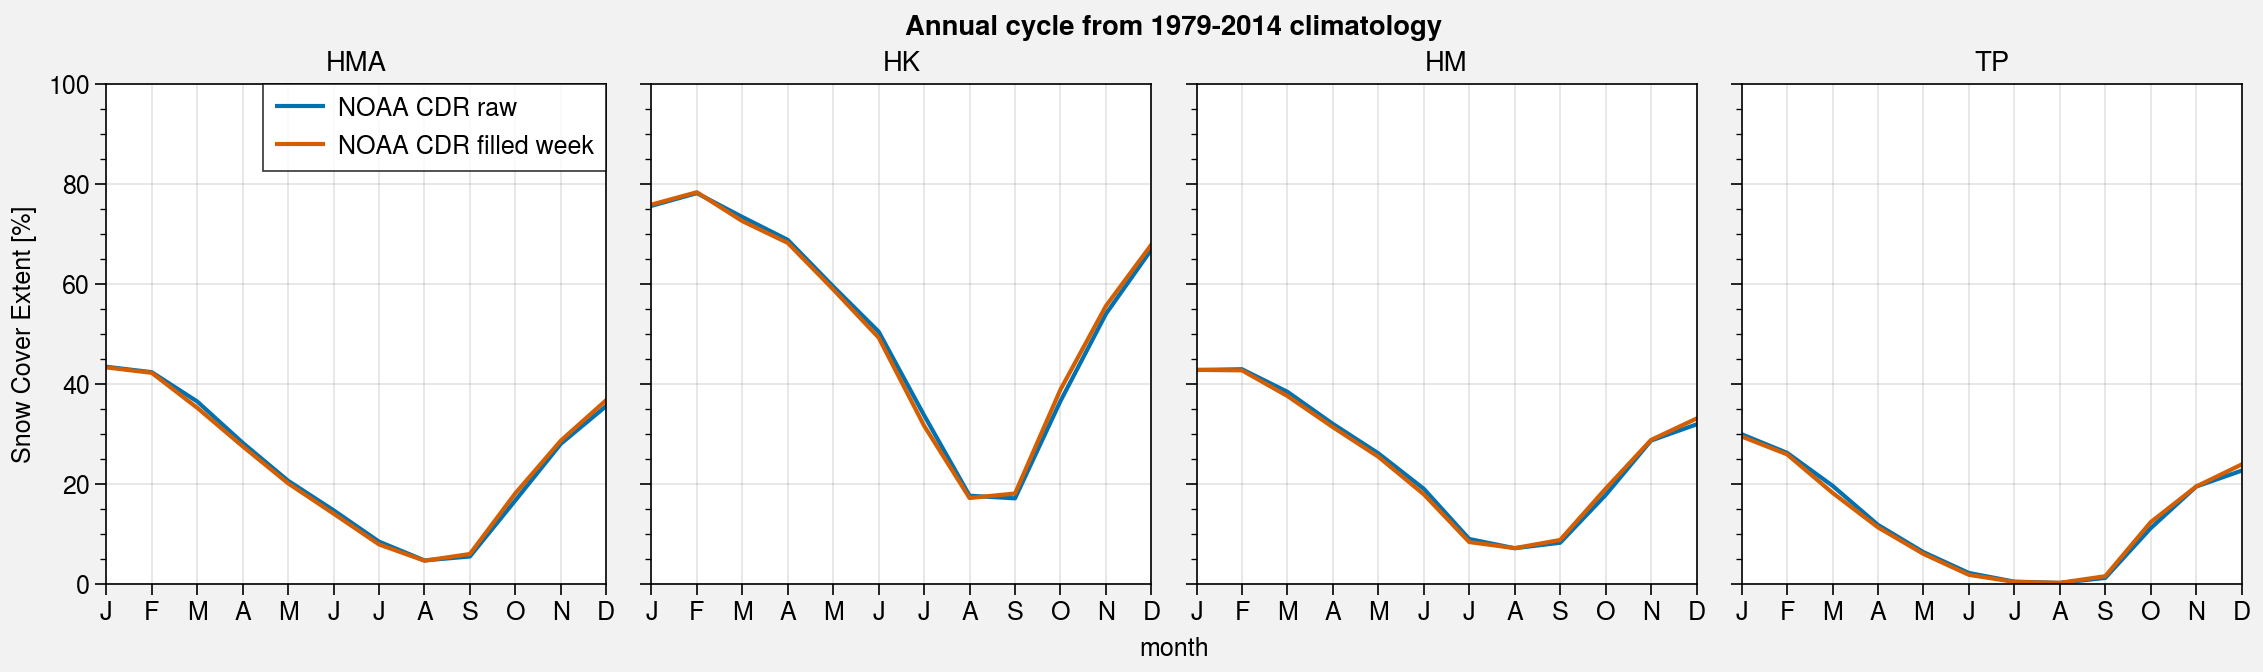

In [7]:
fig, axs = plot.subplots(nrows=1, ncols=4)

for zone, ax in zip(zones, axs):
    h1 = ax.plot(obs_ac_regrid_zones_snc.sel(zone=zone), label='NOAA CDR raw')
    h2 = ax.plot(obs_ac_regrid_zones_snc_filled.sel(zone=zone), label='NOAA CDR filled week')
    ax.format(title=zone)
    
axs[0].legend([h1, h2], ncols=1)
# loc='b', frame=False, ncols=4, order='F', center=False
    
axs.format(
    ylim=(0,100), ylabel='Snow Cover Extent [%]', xlim=(1,12),
    xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
    suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology'
)

# fig.save('img/NOAA_CDR_filled.jpg')

## Check the effect of binaries weekly values

### IPSL

In [10]:
da_day = xr.open_dataset('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/day/snc/gr/latest/snc_day_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc').snc.sel(time=period, lat=latlim_ext, lon=lonlim_ext)
da_mon = xr.open_dataset('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/LImon/snc/gr/latest/snc_LImon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc').snc.sel(time=period, lat=latlim_ext, lon=lonlim_ext)

In [11]:
# da_week = da_day.resample(time='W').mean('time')

# Select just ine day per week
da_week = da_day.isel(time=np.arange(0,da_day.time.size,7))
da_week_bin = da_week.where(da_week > 50, other=0).where(da_week <= 50, other=100) * (da_week*0+1)

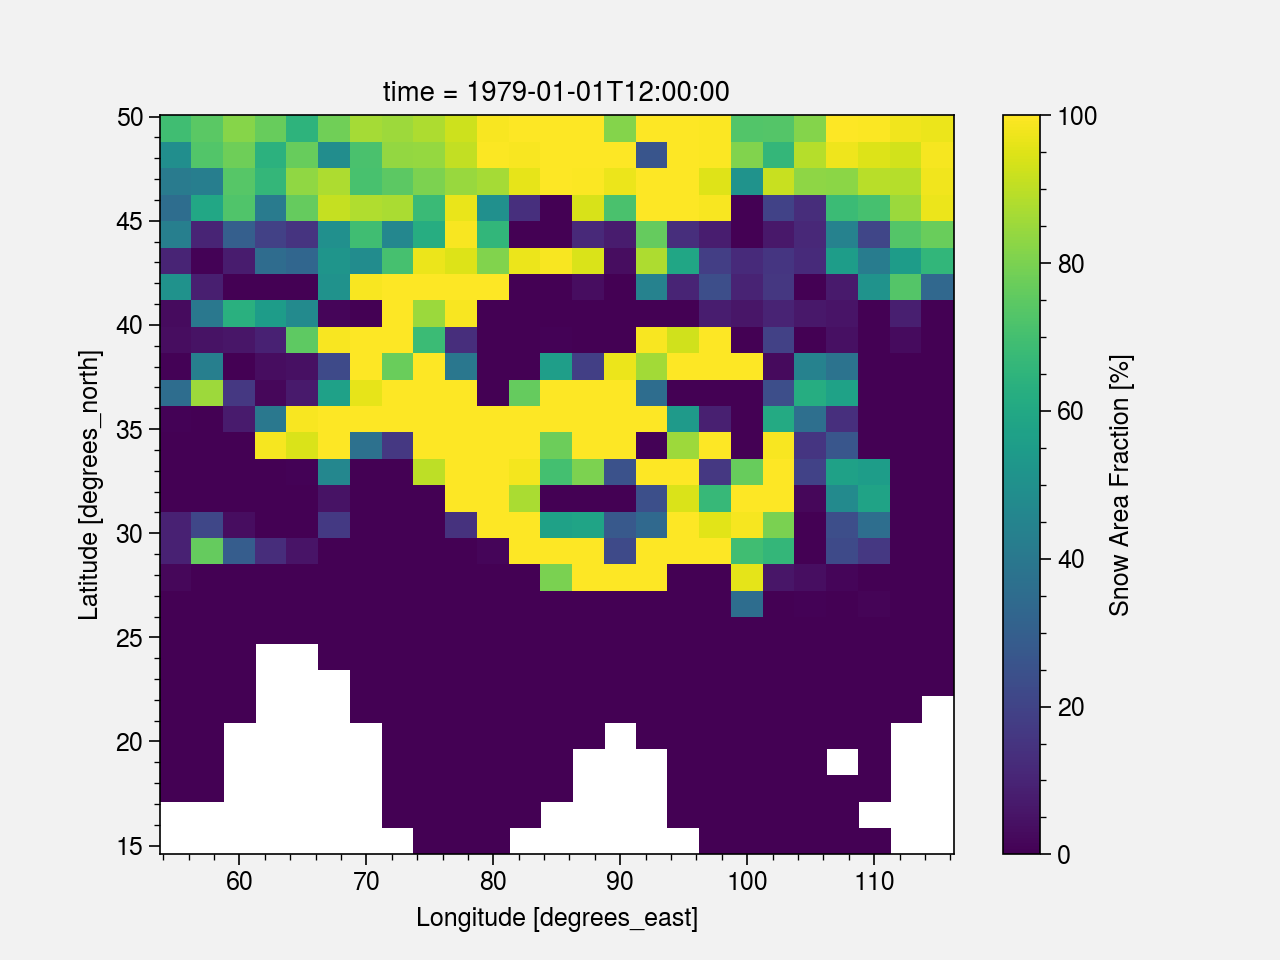

In [23]:
da_week[0].plot()

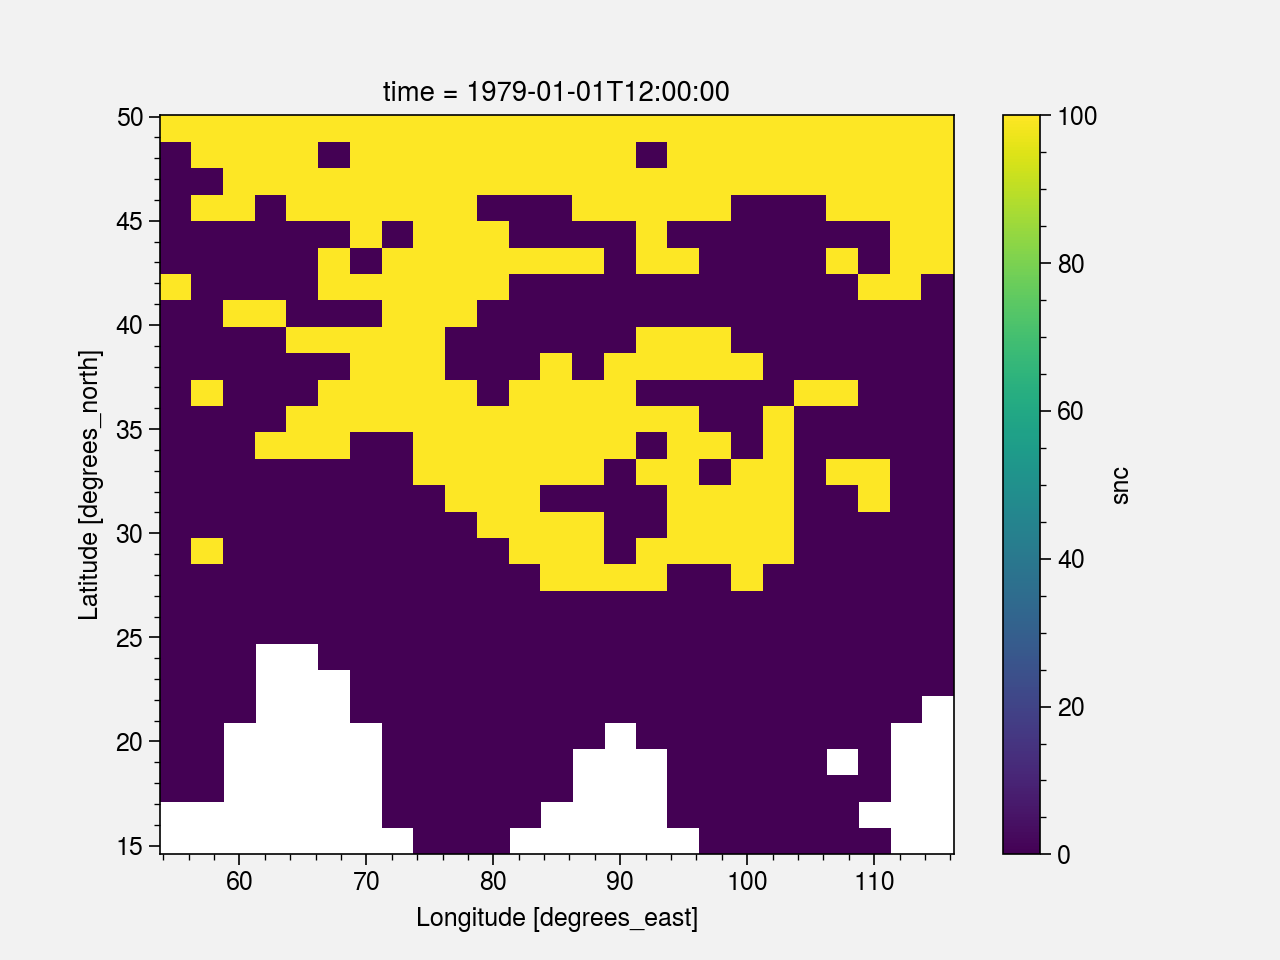

In [24]:
da_week_bin[0].plot()

In [12]:
ac_day = u.annual_cycle(da_day.resample(time='M').mean('time'))
ac_week = u.annual_cycle(da_week.resample(time='M').mean('time'))
ac_week_bin = u.annual_cycle(da_week_bin.resample(time='M').mean('time'))
ac_mon = u.annual_cycle(da_mon)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanme

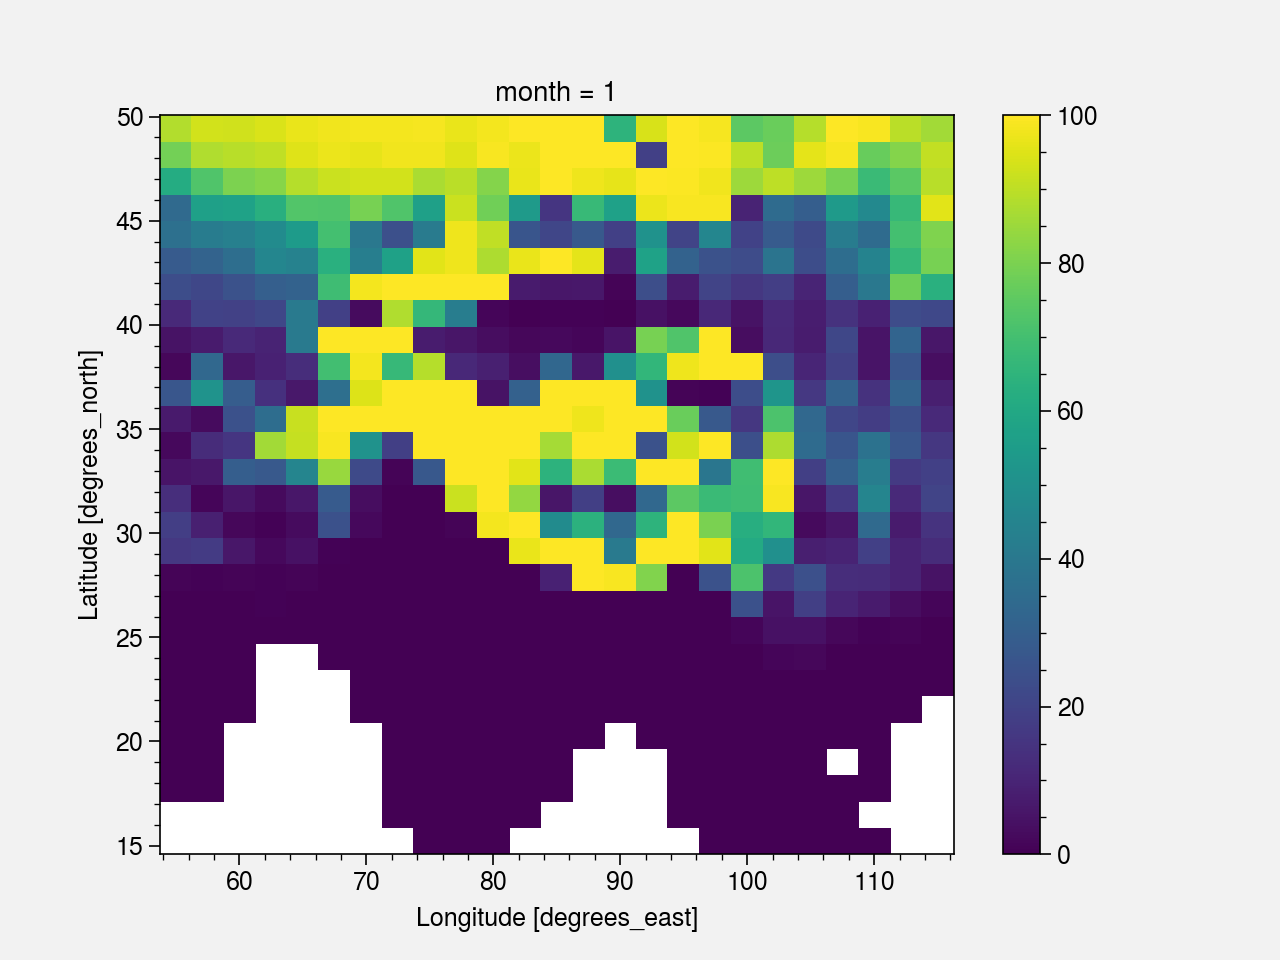

In [19]:
ac_week[0].plot()

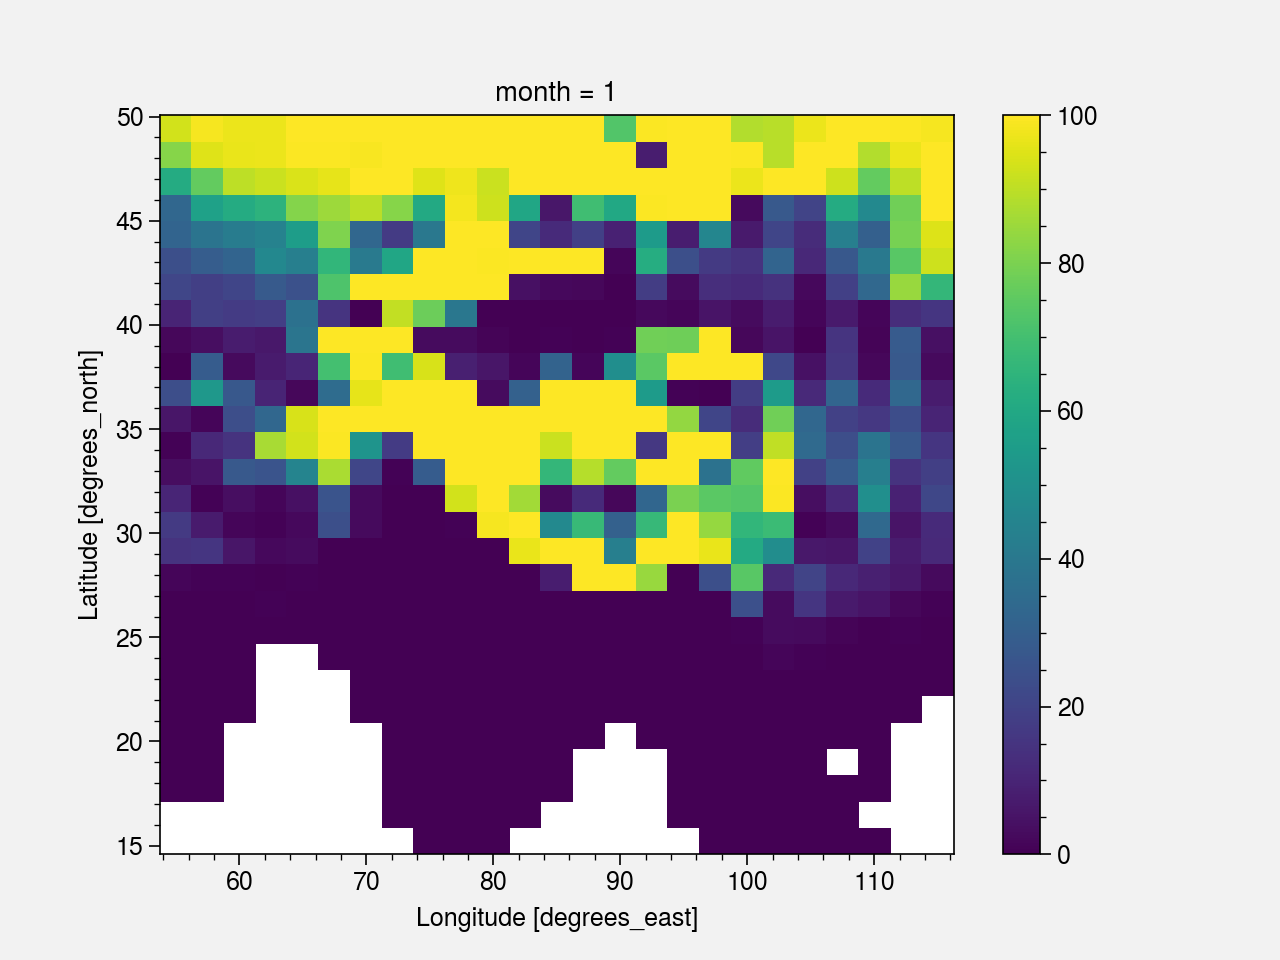

In [20]:
ac_week_bin[0].plot()

In [13]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(ac_day, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp_day = [None]*len(zones)
temp_week = [None]*len(zones)
temp_week_bin = [None]*len(zones)
temp_mon = [None]*len(zones)

ac_regrid_day = regridder(ac_day)
ac_regrid_week = regridder(ac_week)
ac_regrid_week_bin = regridder(ac_week_bin)
ac_regrid_mon = regridder(ac_mon)

for i, zone in enumerate(zones):
    temp_day[i] = u.spatial_average(ac_regrid_day.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
    temp_week[i] = u.spatial_average(ac_regrid_week.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
    temp_week_bin[i] = u.spatial_average(ac_regrid_week_bin.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
    temp_mon[i] = u.spatial_average(ac_regrid_mon.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))

ac_regrid_day_zones = xr.concat(temp_day, pd.Index(zones, name="zone")).load()
ac_regrid_week_zones = xr.concat(temp_week, pd.Index(zones, name="zone")).load()
ac_regrid_week_bin_zones = xr.concat(temp_week_bin, pd.Index(zones, name="zone")).load()
ac_regrid_mon_zones = xr.concat(temp_mon, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_28x25_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


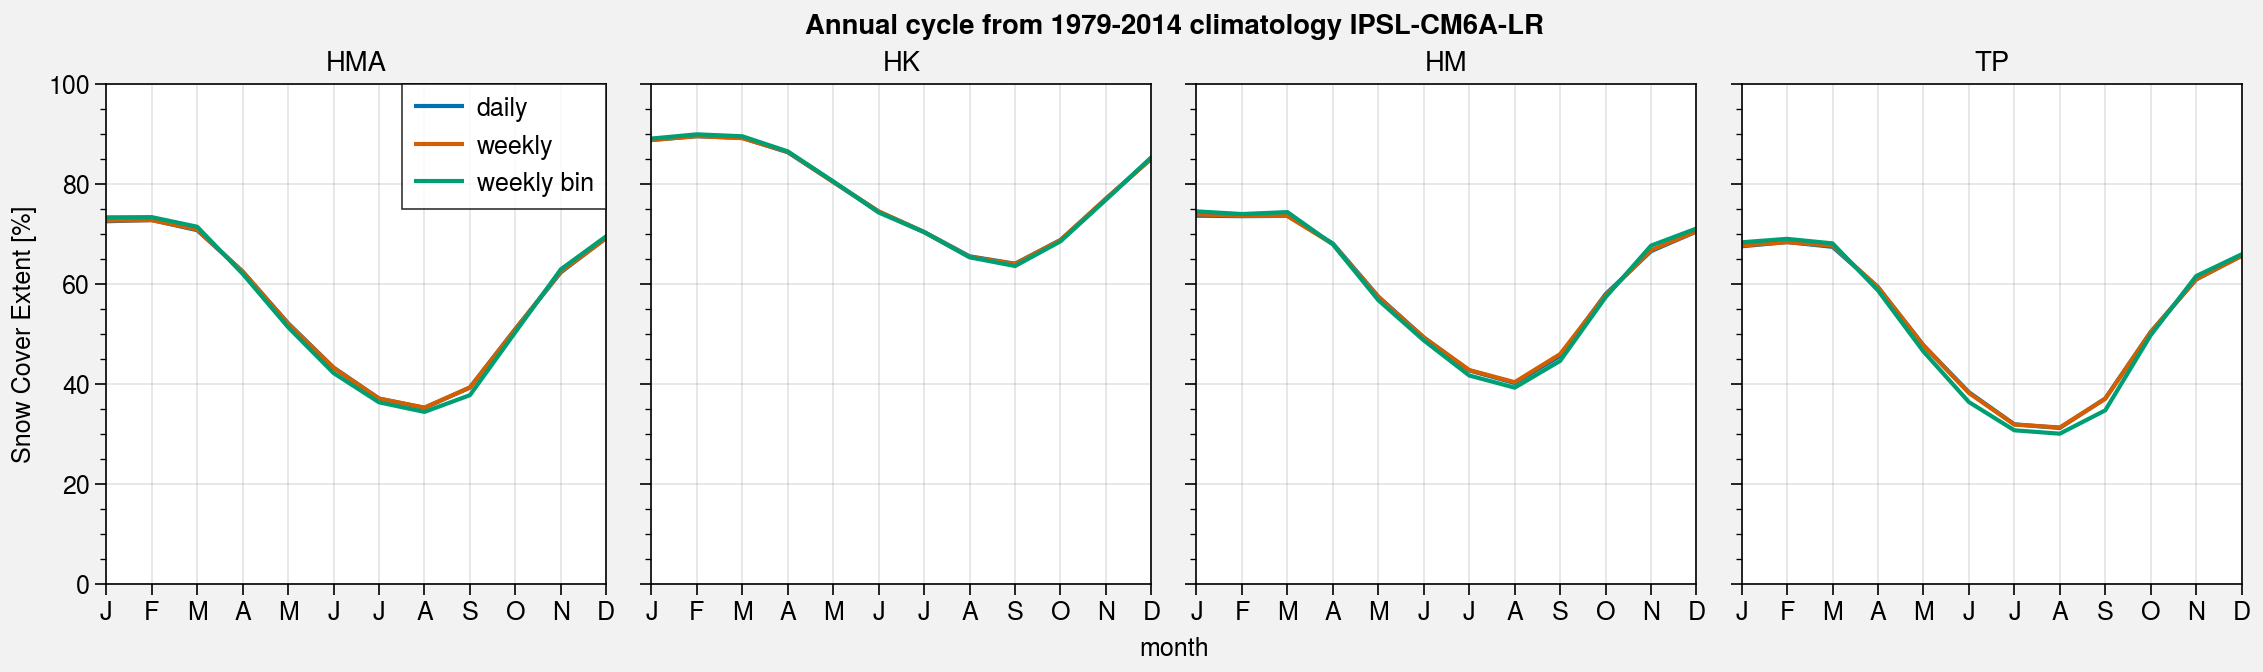

In [211]:
fig, axs = plot.subplots(nrows=1, ncols=4)

for zone, ax in zip(zones, axs):
    h1 = ax.plot(ac_regrid_day_zones.sel(zone=zone), label='daily')
    h2 = ax.plot(ac_regrid_week_zones.sel(zone=zone), label='weekly')
    h3= ax.plot(ac_regrid_week_bin_zones.sel(zone=zone), label='weekly bin')
#     h4 = ax.plot(ac_regrid_mon_zones.sel(zone=zone), label='monthly')
    ax.format(title=zone)
    
axs[0].legend([h1, h2, h3], ncols=1)
# loc='b', frame=False, ncols=4, order='F', center=False
    
axs.format(
    ylim=(0,100), ylabel='Snow Cover Extent [%]', xlim=(1,12),
    xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
    suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology IPSL-CM6A-LR'
)

# fig.save('img/snc_bin_IPSL-CM6A-LR.jpg')

### BCC-ESM1

In [25]:
da_day = xr.open_dataset('/bdd/CMIP6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/day/snc/gn/latest/snc_day_BCC-ESM1_historical_r1i1p1f1_gn_18500101-20141231.nc').snc.sel(time=period, lat=latlim_ext, lon=lonlim_ext)
da_mon = xr.open_dataset('/bdd/CMIP6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/LImon/snc/gn/latest/snc_LImon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc').snc.sel(time=period, lat=latlim_ext, lon=lonlim_ext)

In [46]:
# da_week = da_day.resample(time='W').mean('time')

da_day*=100
da_mon*=100

# Select just ine day per week
da_week = da_day.isel(time=np.arange(0,da_day.time.size,7))
da_week_bin = da_week.where(da_week > 50, other=0).where(da_week <= 50, other=100) * (da_week*0+1)

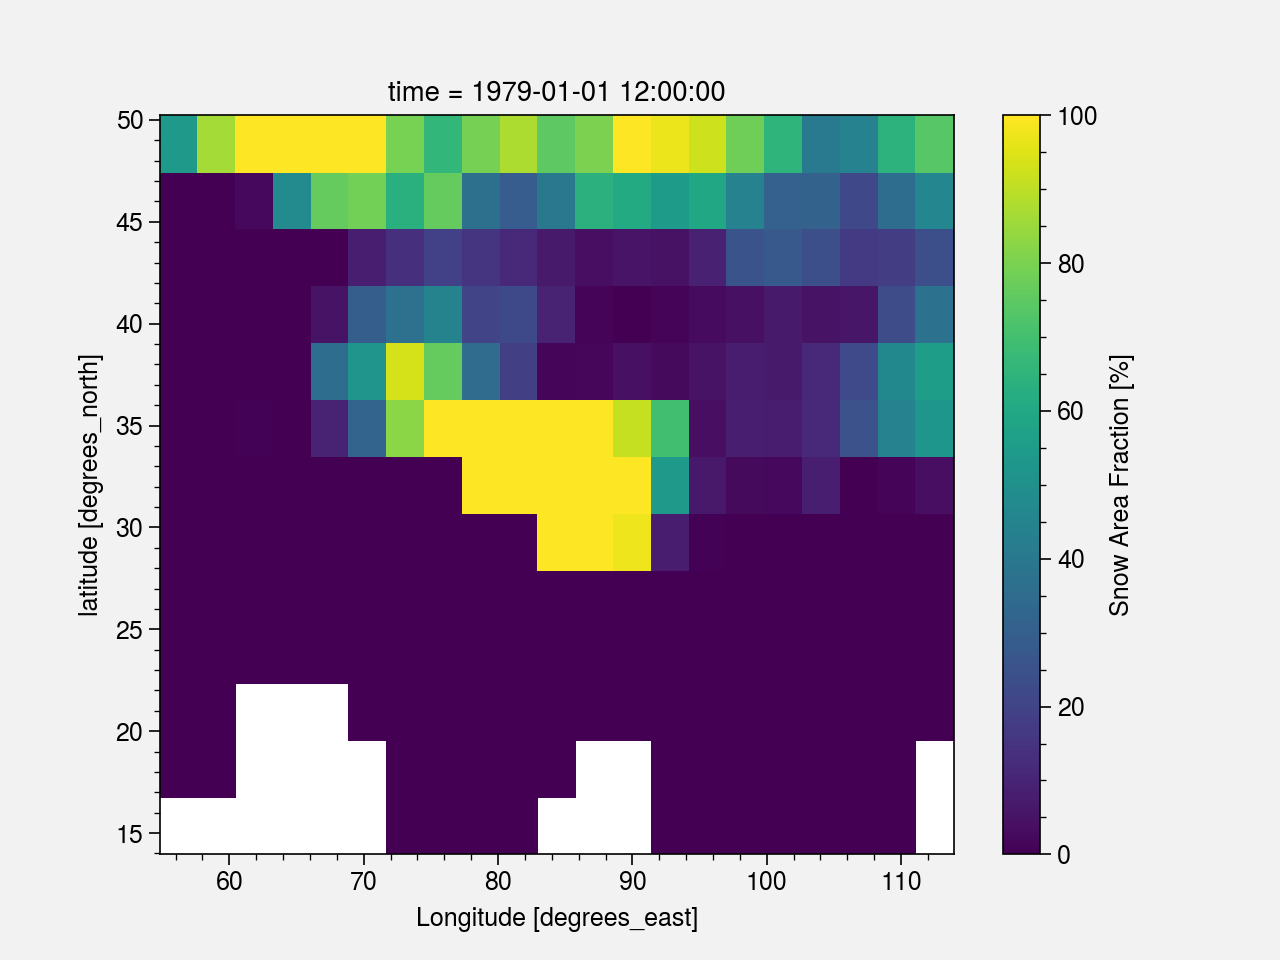

In [47]:
da_week[0].plot()

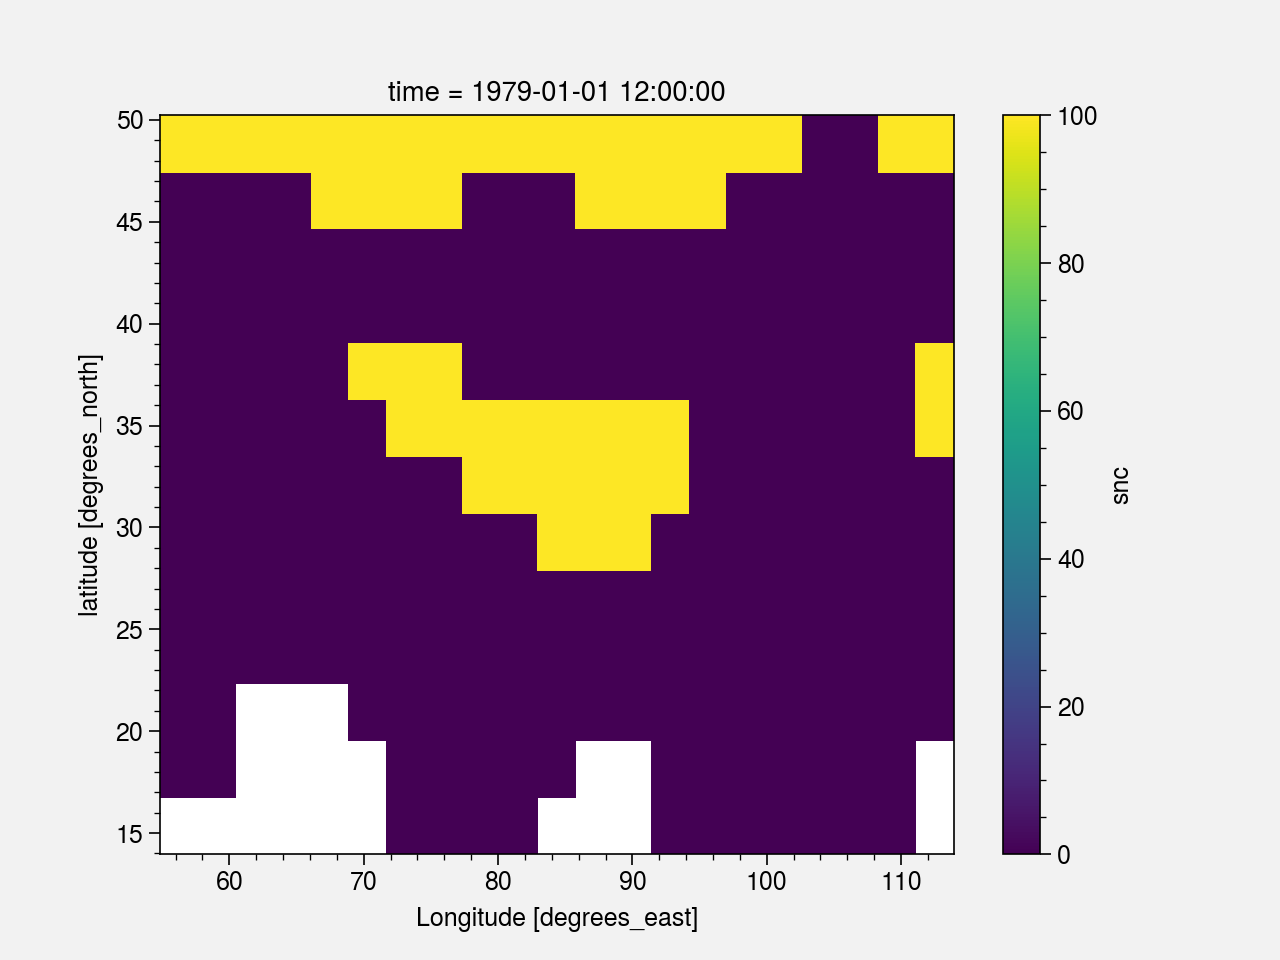

In [48]:
da_week_bin[0].plot()

In [49]:
ac_day = u.annual_cycle(da_day.resample(time='M').mean('time'))
ac_week = u.annual_cycle(da_week.resample(time='M').mean('time'))
ac_week_bin = u.annual_cycle(da_week_bin.resample(time='M').mean('time'))
ac_mon = u.annual_cycle(da_mon)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


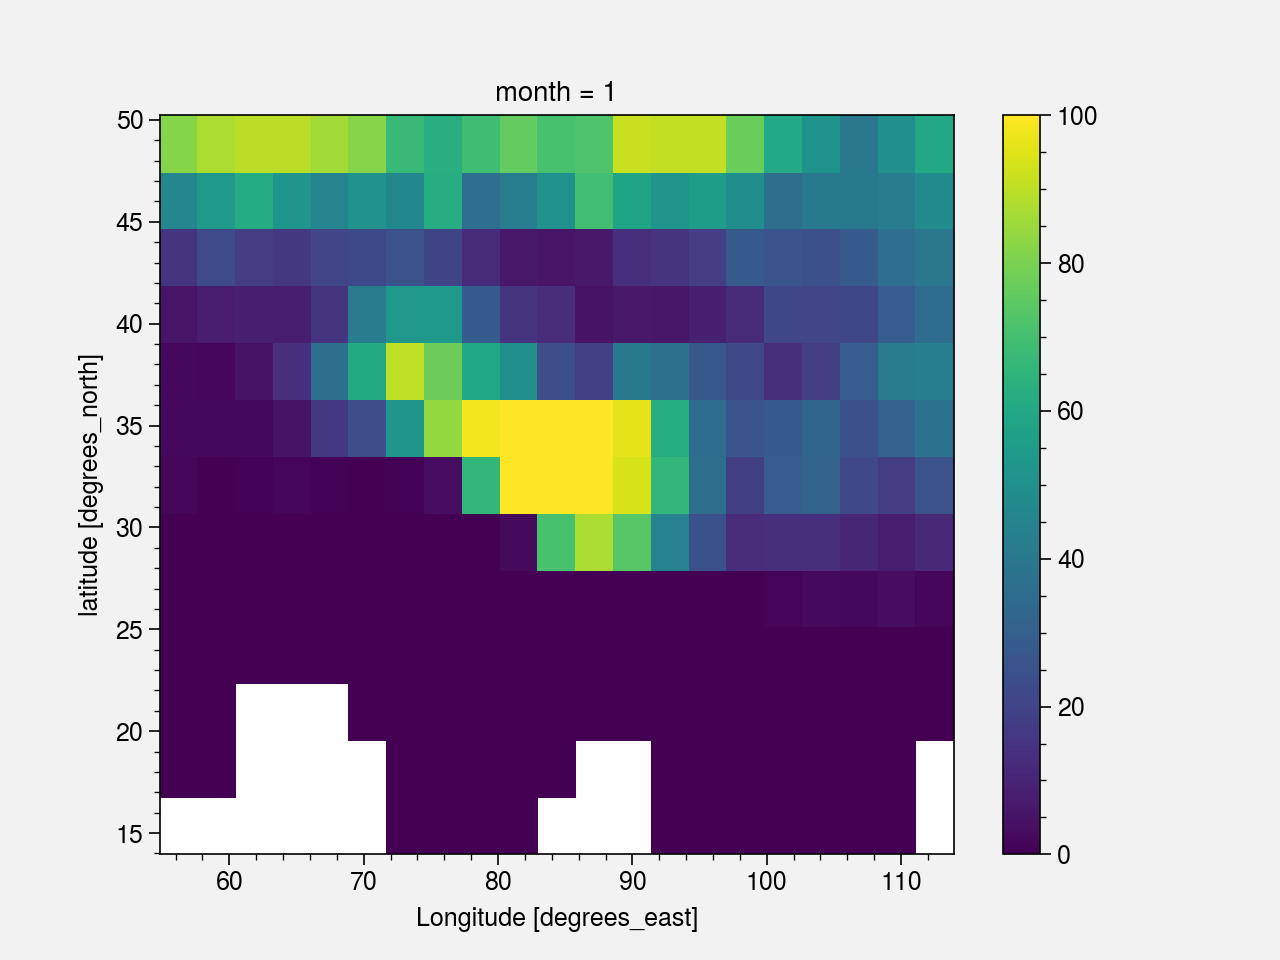

In [50]:
ac_week[0].plot()

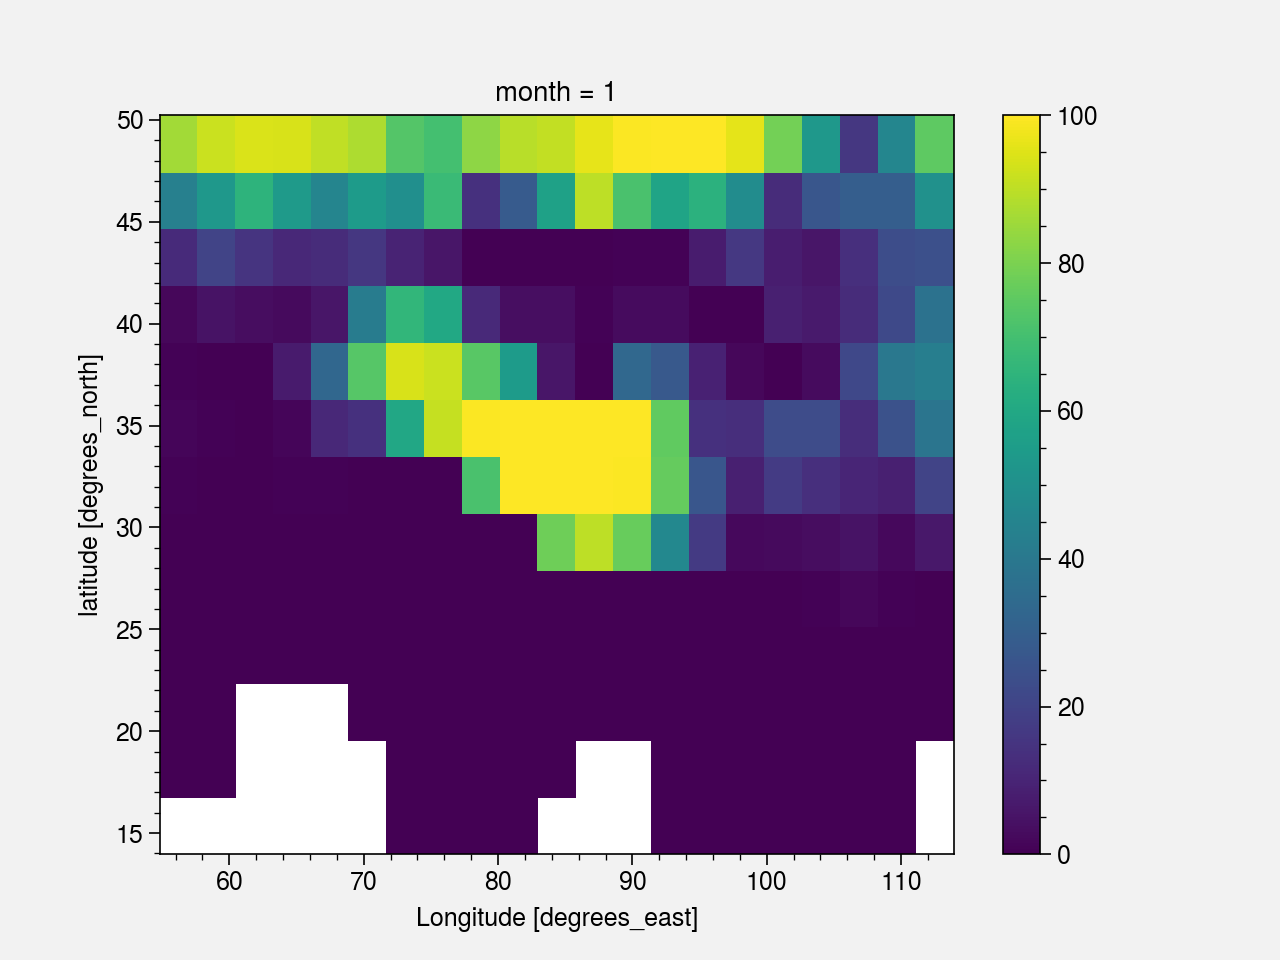

In [51]:
ac_week_bin[0].plot()

In [52]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(ac_day, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp_day = [None]*len(zones)
temp_week = [None]*len(zones)
temp_week_bin = [None]*len(zones)
temp_mon = [None]*len(zones)

ac_regrid_day = regridder(ac_day)
ac_regrid_week = regridder(ac_week)
ac_regrid_week_bin = regridder(ac_week_bin)
ac_regrid_mon = regridder(ac_mon)

for i, zone in enumerate(zones):
    temp_day[i] = u.spatial_average(ac_regrid_day.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
    temp_week[i] = u.spatial_average(ac_regrid_week.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
    temp_week_bin[i] = u.spatial_average(ac_regrid_week_bin.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))
    temp_mon[i] = u.spatial_average(ac_regrid_mon.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500))

ac_regrid_day_zones = xr.concat(temp_day, pd.Index(zones, name="zone")).load()
ac_regrid_week_zones = xr.concat(temp_week, pd.Index(zones, name="zone")).load()
ac_regrid_week_bin_zones = xr.concat(temp_week_bin, pd.Index(zones, name="zone")).load()
ac_regrid_mon_zones = xr.concat(temp_mon, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_13x21_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


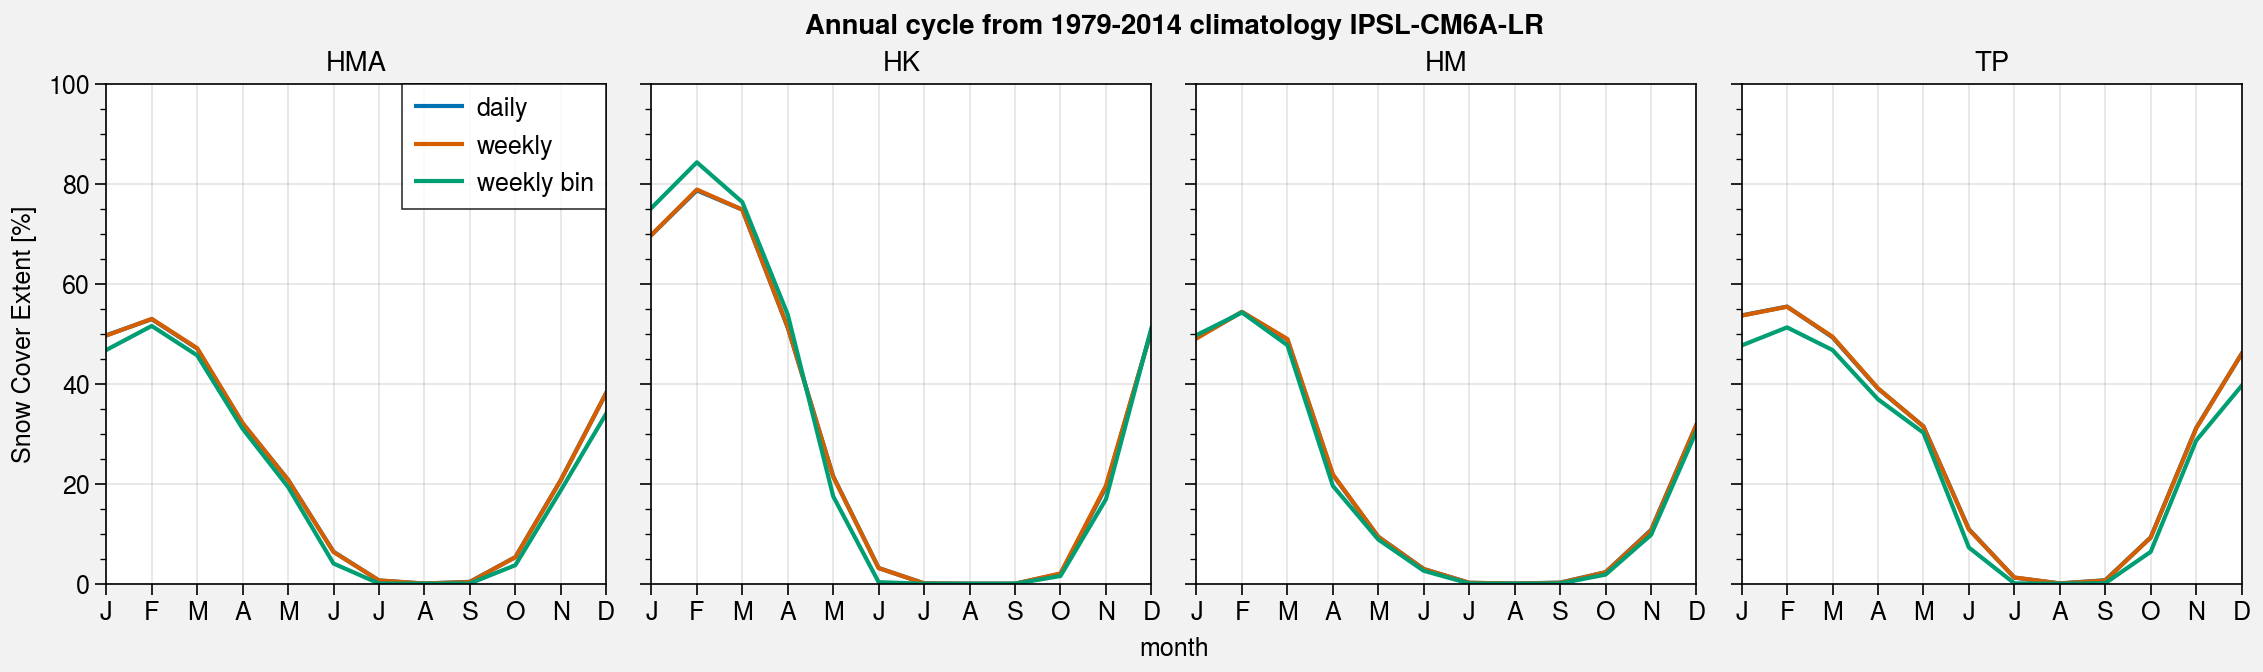

In [53]:
fig, axs = plot.subplots(nrows=1, ncols=4)

for zone, ax in zip(zones, axs):
    h1 = ax.plot(ac_regrid_day_zones.sel(zone=zone), label='daily')
    h2 = ax.plot(ac_regrid_week_zones.sel(zone=zone), label='weekly')
    h3= ax.plot(ac_regrid_week_bin_zones.sel(zone=zone), label='weekly bin')
#     h4 = ax.plot(ac_regrid_mon_zones.sel(zone=zone), label='monthly')
    ax.format(title=zone)
    
axs[0].legend([h1, h2, h3], ncols=1)
# loc='b', frame=False, ncols=4, order='F', center=False
    
axs.format(
    ylim=(0,100), ylabel='Snow Cover Extent [%]', xlim=(1,12),
    xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
    suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology IPSL-CM6A-LR'
)

fig.save('img/snc_bin_BCC-ESM1.jpg')

### Precipitation

#### APHRODITE

In [17]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = (xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')).sel(time=period)

# Resamble data per month (from per day)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [18]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_pr_aphro = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_140x180_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### GPCP

In [19]:
obs_longname = 'GPCP CDR v2.3 (2.5°)'
obs_name = 'GPCP'

obs = xr.open_mfdataset(
    # '/bdd/GPCP/netcdf/surf-rr_gpcp_multi-sat_250d_01mth_*_v2.2-02.nc', combine='by_coords'
    # -> missing some month (ex 2014/11)
    '/data/mlalande/GPCP/CDR_monthly_v2.3/*/gpcp_v02r03_monthly_d*_c20170616.nc'
).precip.sel(time=period, latitude=latlim_ext, longitude=lonlim_ext)

obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')

In [20]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_pr_gpcp = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_14x24_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Load results

In [34]:
# list_vars = ['tas', 'snc', 'pr']
list_vars = ['snc']
temp = [None]*len(list_vars)

for i, var in enumerate(list_vars):
    temp[i] = xr.open_dataarray(
        'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_ac.nc'
    )
    
multimodel_ensemble_ac = xr.concat(temp, pd.Index(list_vars, name='var'))

In [13]:
# multimodel_ensemble_ac

## Plot

In [35]:
path = '/data/mlalande/ESACCI/ESA_CCI_snow_SCFG_v1.0_HKH_gapfilled_monthly'

In [36]:
esa_snc = xr.open_dataarray(path+'/ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv1.0_HKH_gapfilled_montlhy_1982-2014.nc')
esa_snc_icefilled = xr.open_dataarray(path+'/ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv1.0_HKH_gapfilled_icefilled_montlhy_1982-2014.nc')
esa_snc

<xarray.DataArray 'snc' (time: 396, lat: 500, lon: 1000)>
[198000000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2014-12-31
  * lon      (lon) float64 60.02 60.08 60.12 60.17 ... 109.8 109.9 109.9 110.0
  * lat      (lat) float64 44.98 44.92 44.88 44.83 ... 20.17 20.12 20.07 20.02

In [37]:
regridder = xe.Regridder(elevation_HR, esa_snc, 'bilinear', periodic=False, reuse_weights=True)
elevation_HR_regrid = regridder(elevation_HR)

Reuse existing file: bilinear_560x960_500x1000.nc


In [38]:
esa_snc_mon = esa_snc.groupby('time.month').mean('time')
esa_snc_icefilled_mon = esa_snc_icefilled.groupby('time.month').mean('time')
noaa_snc_mon = noaa_snc.groupby('time.month').mean('time')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


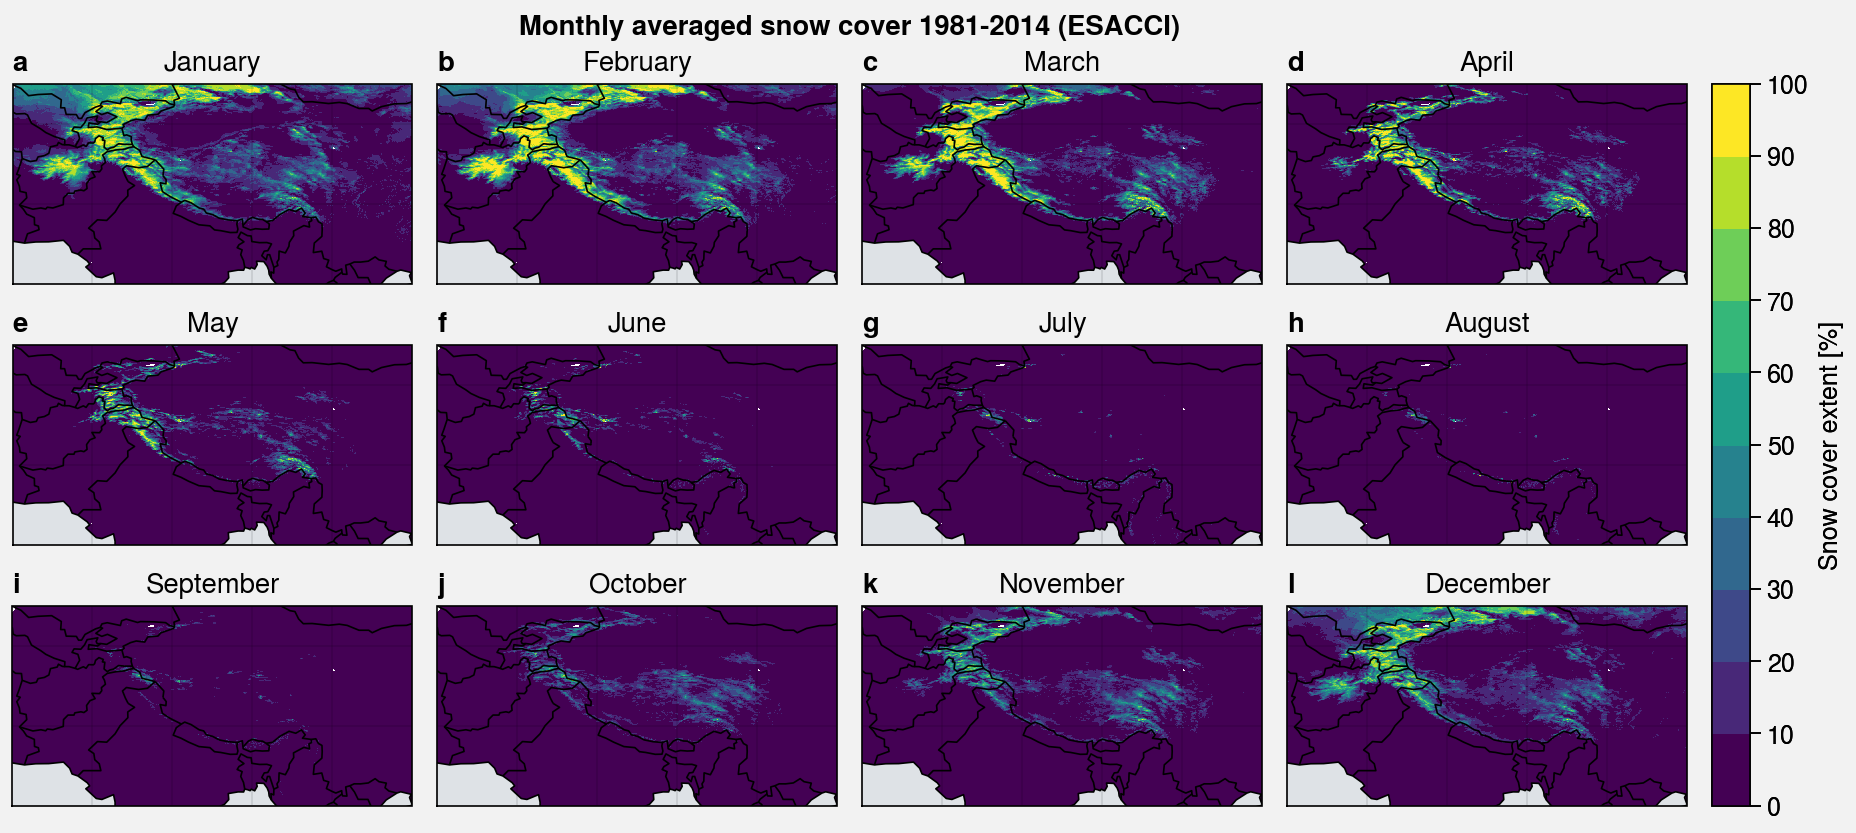

In [39]:
import calendar
cmap='viridis'
levels=plot.arange(0,100,10)
var_label = 'Snow cover extent [%]'

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=2)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        esa_snc_mon.isel(month=i), 
        cmap=cmap,  
        levels=levels,
        extend='neither'
    )
    ax.format(title=calendar.month_name[i+1])
    
f.colorbar(m, label=var_label)

axs.format(
    labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Monthly averaged snow cover 1981-2014 (ESACCI)',
    lonlines=10, latlines=10, abc=True, latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

# f.save('img/mon_ESACCI_1981-2014.jpg')

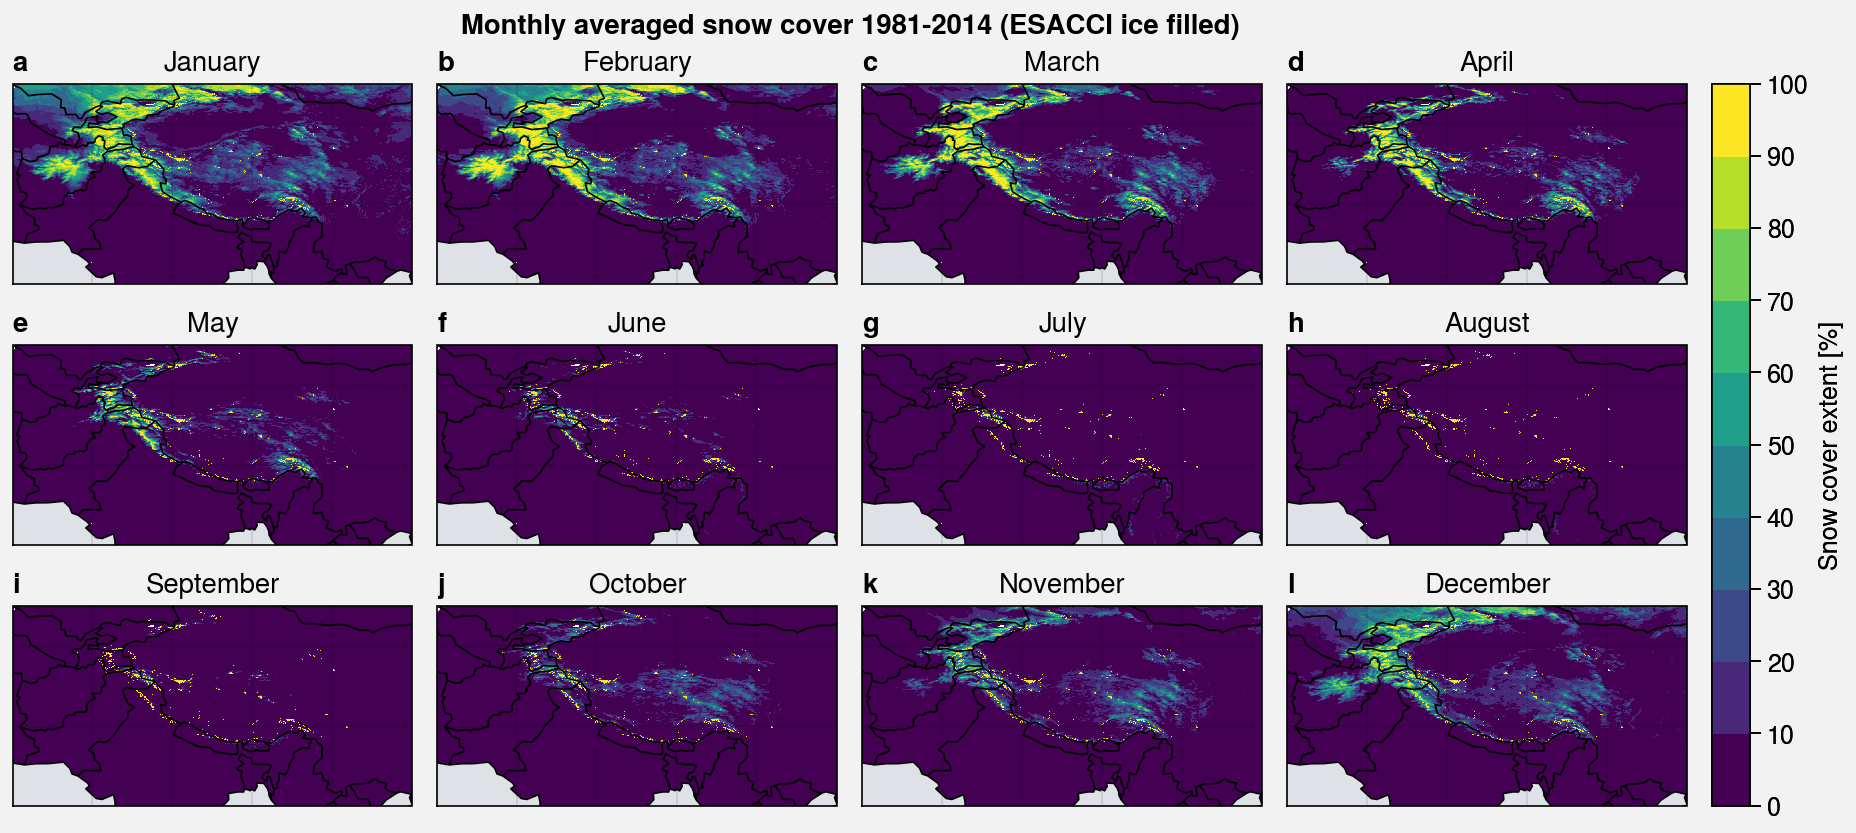

In [40]:
import calendar
cmap='viridis'
levels=plot.arange(0,100,10)
var_label = 'Snow cover extent [%]'

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=2)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        esa_snc_icefilled_mon.isel(month=i), 
        cmap=cmap,  
        levels=levels,
        extend='neither'
    )
    ax.format(title=calendar.month_name[i+1])
    
f.colorbar(m, label=var_label)

axs.format(
    labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Monthly averaged snow cover 1981-2014 (ESACCI ice filled)',
    lonlines=10, latlines=10, abc=True, latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

f.save('img/mon_ESACCI_icefilled_1981-2014.jpg')

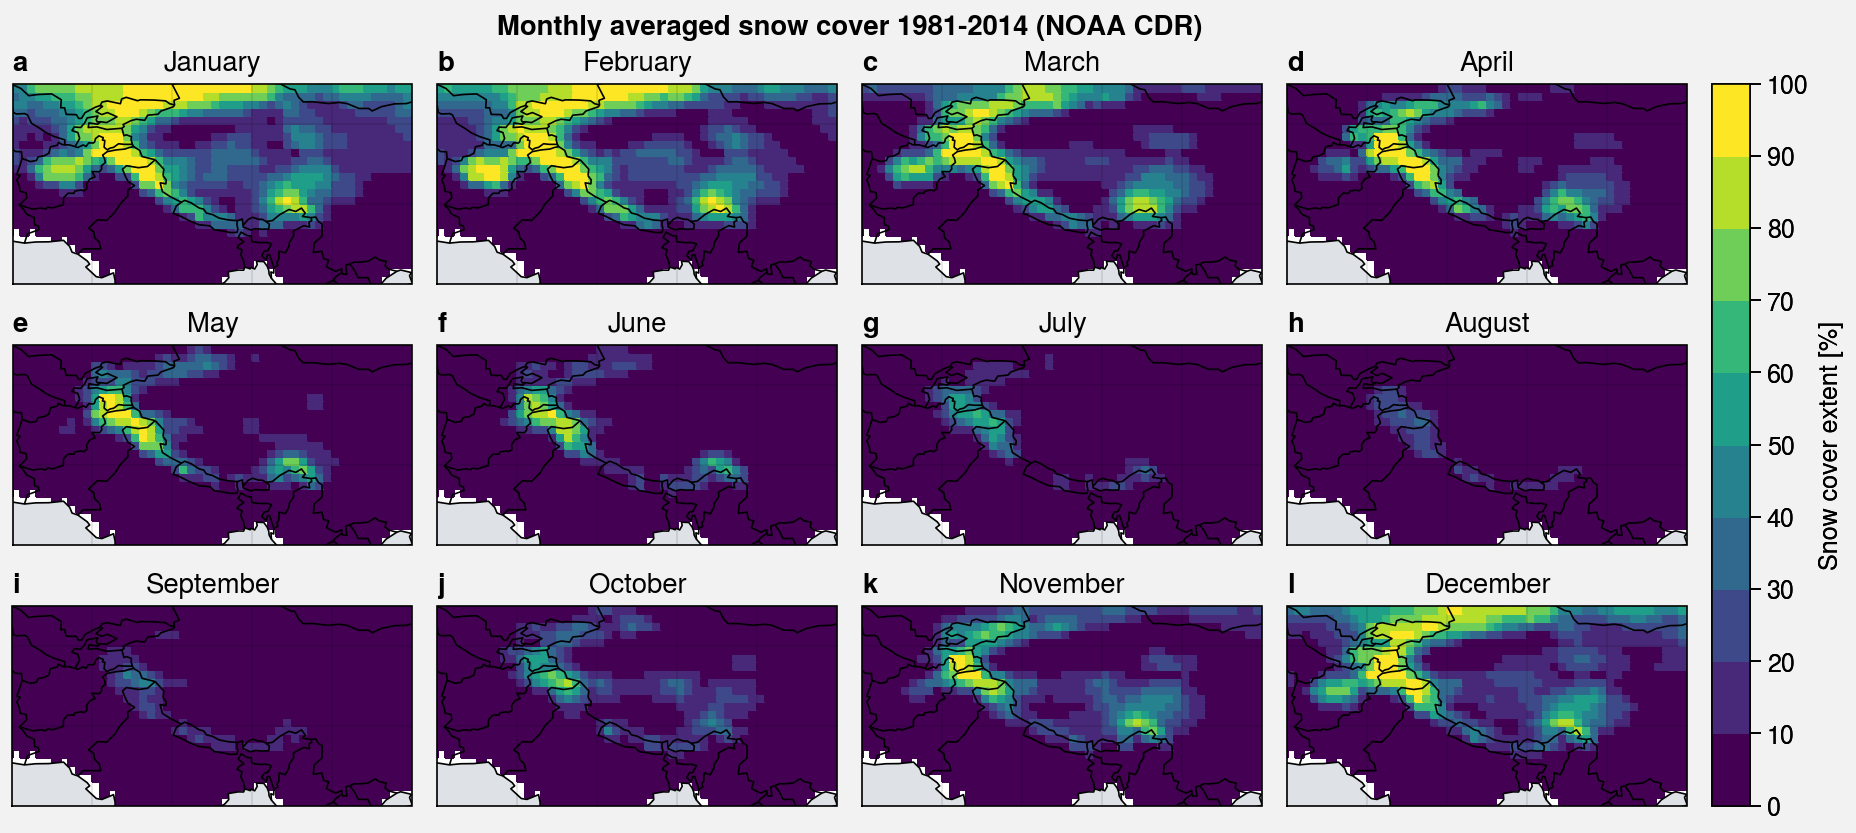

In [41]:
import calendar
cmap='viridis'
levels=plot.arange(0,100,10)
var_label = 'Snow cover extent [%]'

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=2)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        noaa_snc_mon.isel(month=i), 
        cmap=cmap,  
        levels=levels,
        extend='neither'
    )
    ax.format(title=calendar.month_name[i+1])
    
f.colorbar(m, label=var_label)

axs.format(
    labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Monthly averaged snow cover 1981-2014 (NOAA CDR)',
    lonlines=10, latlines=10, abc=True, latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

# f.save('img/mon_NOAA-CDR_1981-2014.jpg')

In [117]:
temp = [None]*len(zones)
esa_snc_ac = esa_snc.groupby('time.month').mean('time') # otherwise bug with u.annual_cycle (0 on glaciers instead of nan)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        esa_snc_ac.sel(lat=slice(zones_df.latlim[zone].stop, zones_df.latlim[zone].start), lon=zones_df.lonlim[zone]).where(elevation_HR_regrid > 2500)
    )

esa_snc_ac_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

In [118]:
temp = [None]*len(zones)
esa_snc_ac_icefilled = esa_snc_icefilled.groupby('time.month').mean('time') # otherwise bug with u.annual_cycle (0 on glaciers instead of nan)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        esa_snc_ac_icefilled.sel(lat=slice(zones_df.latlim[zone].stop, zones_df.latlim[zone].start), lon=zones_df.lonlim[zone]).where(elevation_HR_regrid > 2500)
    )

esa_snc_ac_icefilled_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

In [122]:
zone = 'HK'
esa_snc_ac.sel(lat=slice(zones_df.latlim[zone].stop, zones_df.latlim[zone].start), lon=zones_df.lonlim[zone]).where(elevation_HR_regrid > 2500)[0]

<xarray.DataArray 'snc' (lat: 180, lon: 220)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., 41.84063898,
        42.83405587, 44.03404009],
       [        nan,         nan,         nan, ..., 43.66349208,
        43.84607562, 44.72454629],
       [        nan,         nan,         nan, ..., 42.61815786,
        44.16125373, 46.11723246]])
Coordinates:
  * lat      (lat) float64 39.98 39.92 39.88 39.83 ... 31.17 31.12 31.07 31.02
  * lon      (lon) float64 70.03 70.08 70.12 70.17 ... 80.83 80.88 80.92 80.97
    month    int64 1

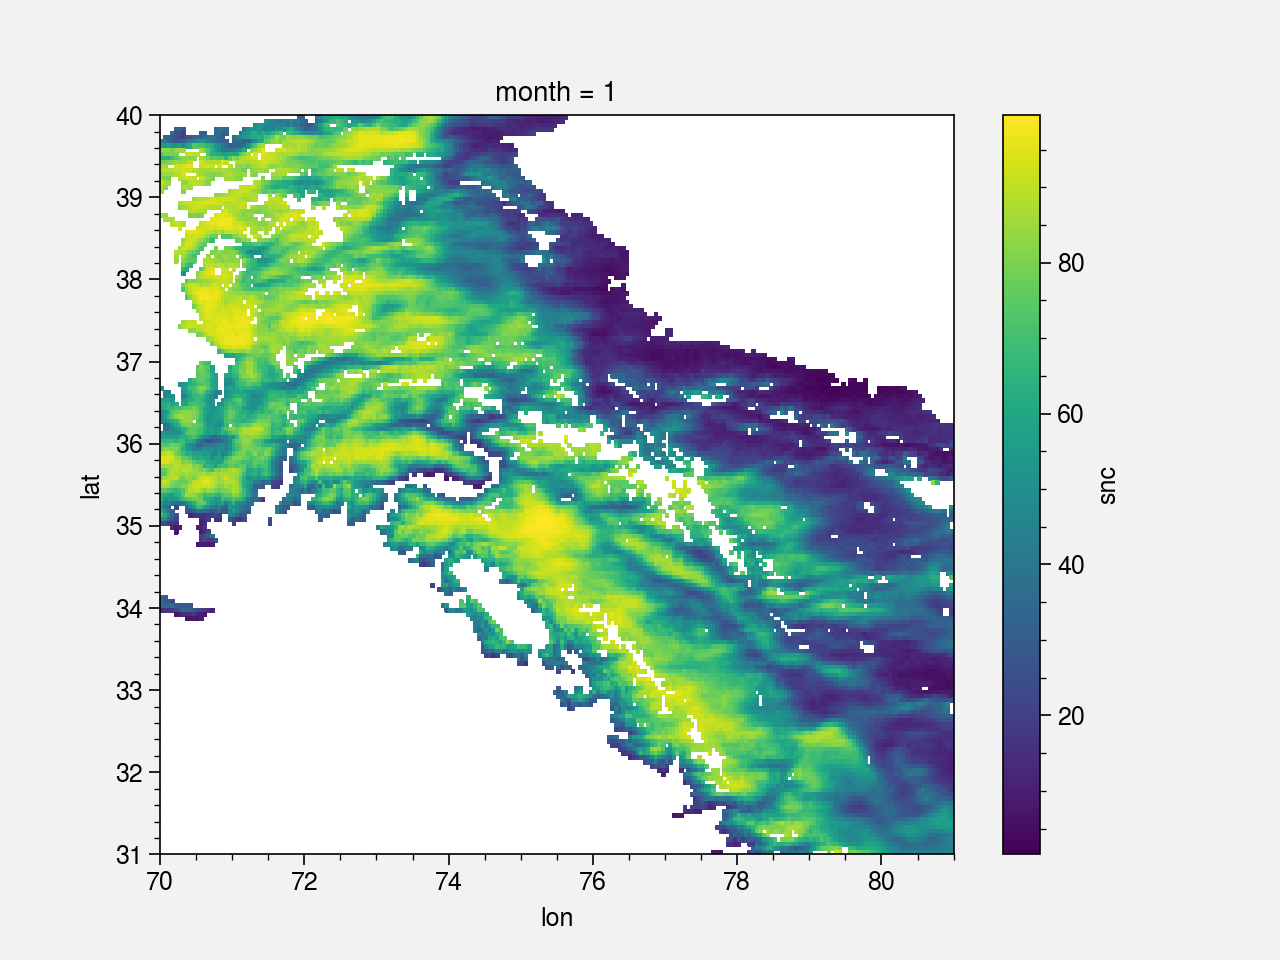

In [123]:
esa_snc_ac.sel(lat=slice(zones_df.latlim[zone].stop, zones_df.latlim[zone].start), lon=zones_df.lonlim[zone]).where(elevation_HR_regrid > 2500)[0].plot()

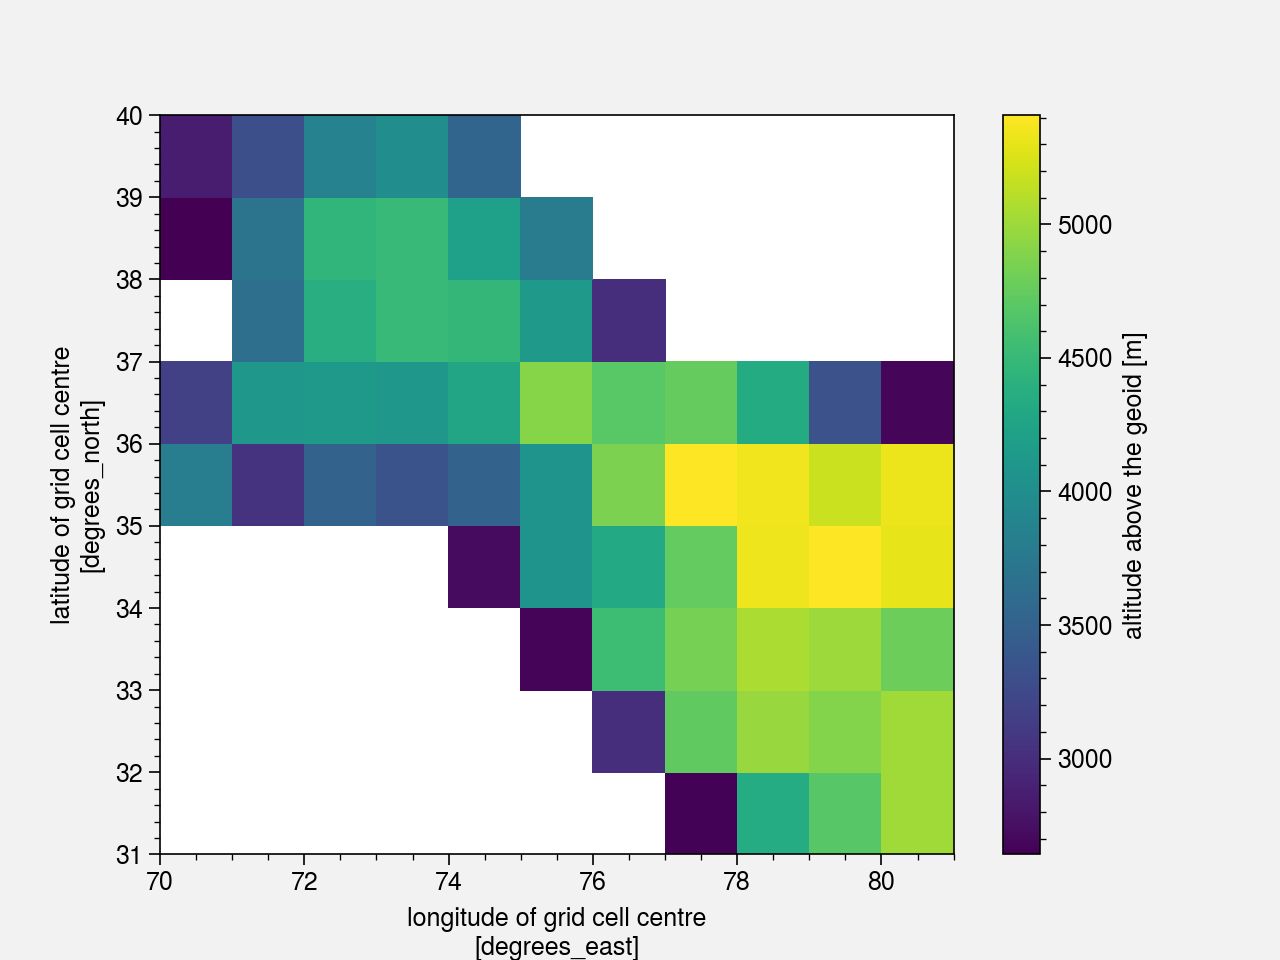

In [124]:
elevation.sel(lat=slice(zones_df.latlim[zone].start, zones_df.latlim[zone].stop), lon=zones_df.lonlim[zone]).where(elevation > 2500).plot()

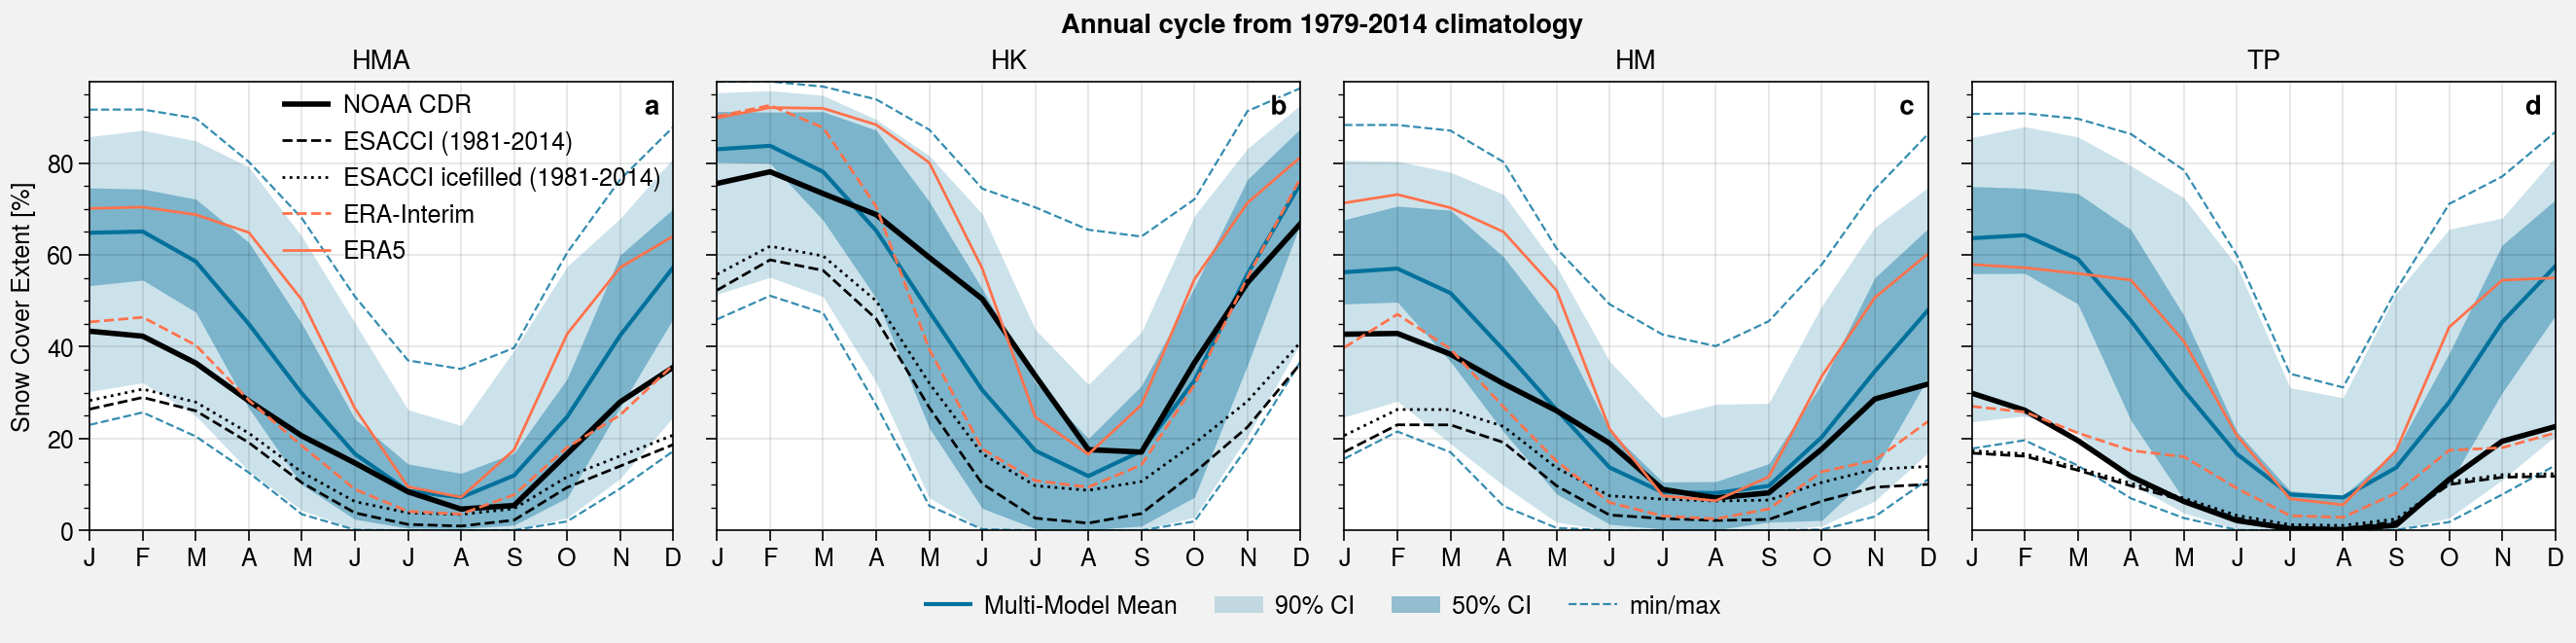

In [128]:
f, axs = plot.subplots(ncols=4, nrows=1, aspect=1.3, sharey=0, axwidth=3)

color_model = 'ocean blue'
color_obs = 'black'
color_era = 'pink orange'

n_ax = 0
for i_var, var in enumerate(['snc']):
    for i in range(len(zones)):
        means = multimodel_ensemble_ac.sel(var=var)[i].mean('model')

        # Compute quantiles  
        shadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.25, 0.75], dim='model')  # dark shading
        fadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.05, 0.95], dim='model')  # light shading

        h1 = axs[n_ax].plot(
            means, 
            shadedata=shadedata, fadedata=fadedata,
            shadelabel='50% CI', fadelabel='90% CI',
            label='Multi-Model Mean', color=color_model, 
        )

        # Add min/max
        h2 = axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].min('model'),
            label='min/max', linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )
        axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].max('model'),
            linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )

        # Plot observations
        h3 = axs[n_ax].plot(obs_ac_regrid_zones_snc[i], label='NOAA CDR', color=color_obs, linewidth=2)
        h4 = axs[n_ax].plot(esa_snc_ac_zones[i], label='ESACCI (1981-2014)', color=color_obs, linewidth=1, linestyle='--')
        h5 = axs[n_ax].plot(esa_snc_ac_icefilled_zones[i], label='ESACCI icefilled (1981-2014)', color=color_obs, linewidth=1, linestyle=':')
        h6 = axs[n_ax].plot(obs_ac_regrid_zones_snc_erai[i], label='ERA-Interim', color=color_era, linewidth=1, linestyle='--')
        h7 = axs[n_ax].plot(obs_ac_regrid_zones_snc_era5[i], label='ERA5', color=color_era, linewidth=1)

        
        if i == 0:
            axs[n_ax].format( 
                ylim=(multimodel_ensemble_ac.sel(var=var).min(), multimodel_ensemble_ac.sel(var=var).max()),
                xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
                xlabel=''
            )
        else:
            axs[n_ax].format( 
                ylim=(multimodel_ensemble_ac.sel(var=var).min(), multimodel_ensemble_ac.sel(var=var).max()),
                xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
                xlabel='',
                yticklabels=[]
            )
            
        
        if i_var == 0:
            axs[n_ax].format(title=zones[n_ax])
        
        # Add obs legend and ylabel
        if i == 0:
            h = [h3, h4, h5, h6, h7]
            loc = 'ur'

            axs[n_ax].legend(h, loc=loc, frame=False, ncols=1)
            
            labels=['Snow Cover Extent [%]']
            axs[n_ax].format( 
                ylabel = labels[i_var]
            )
        
        n_ax += 1

f.legend([h1[0], h1[1], h1[2], h2], loc='b', frame=False, ncols=4, order='F', center=False)

axs.format(
    suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology',
#     collabels=zones,
    abc=True, abcloc='ur'
)
    
filename = 'ac_snc_ESACCI_'+period.start+'-'+period.stop
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

# All variables

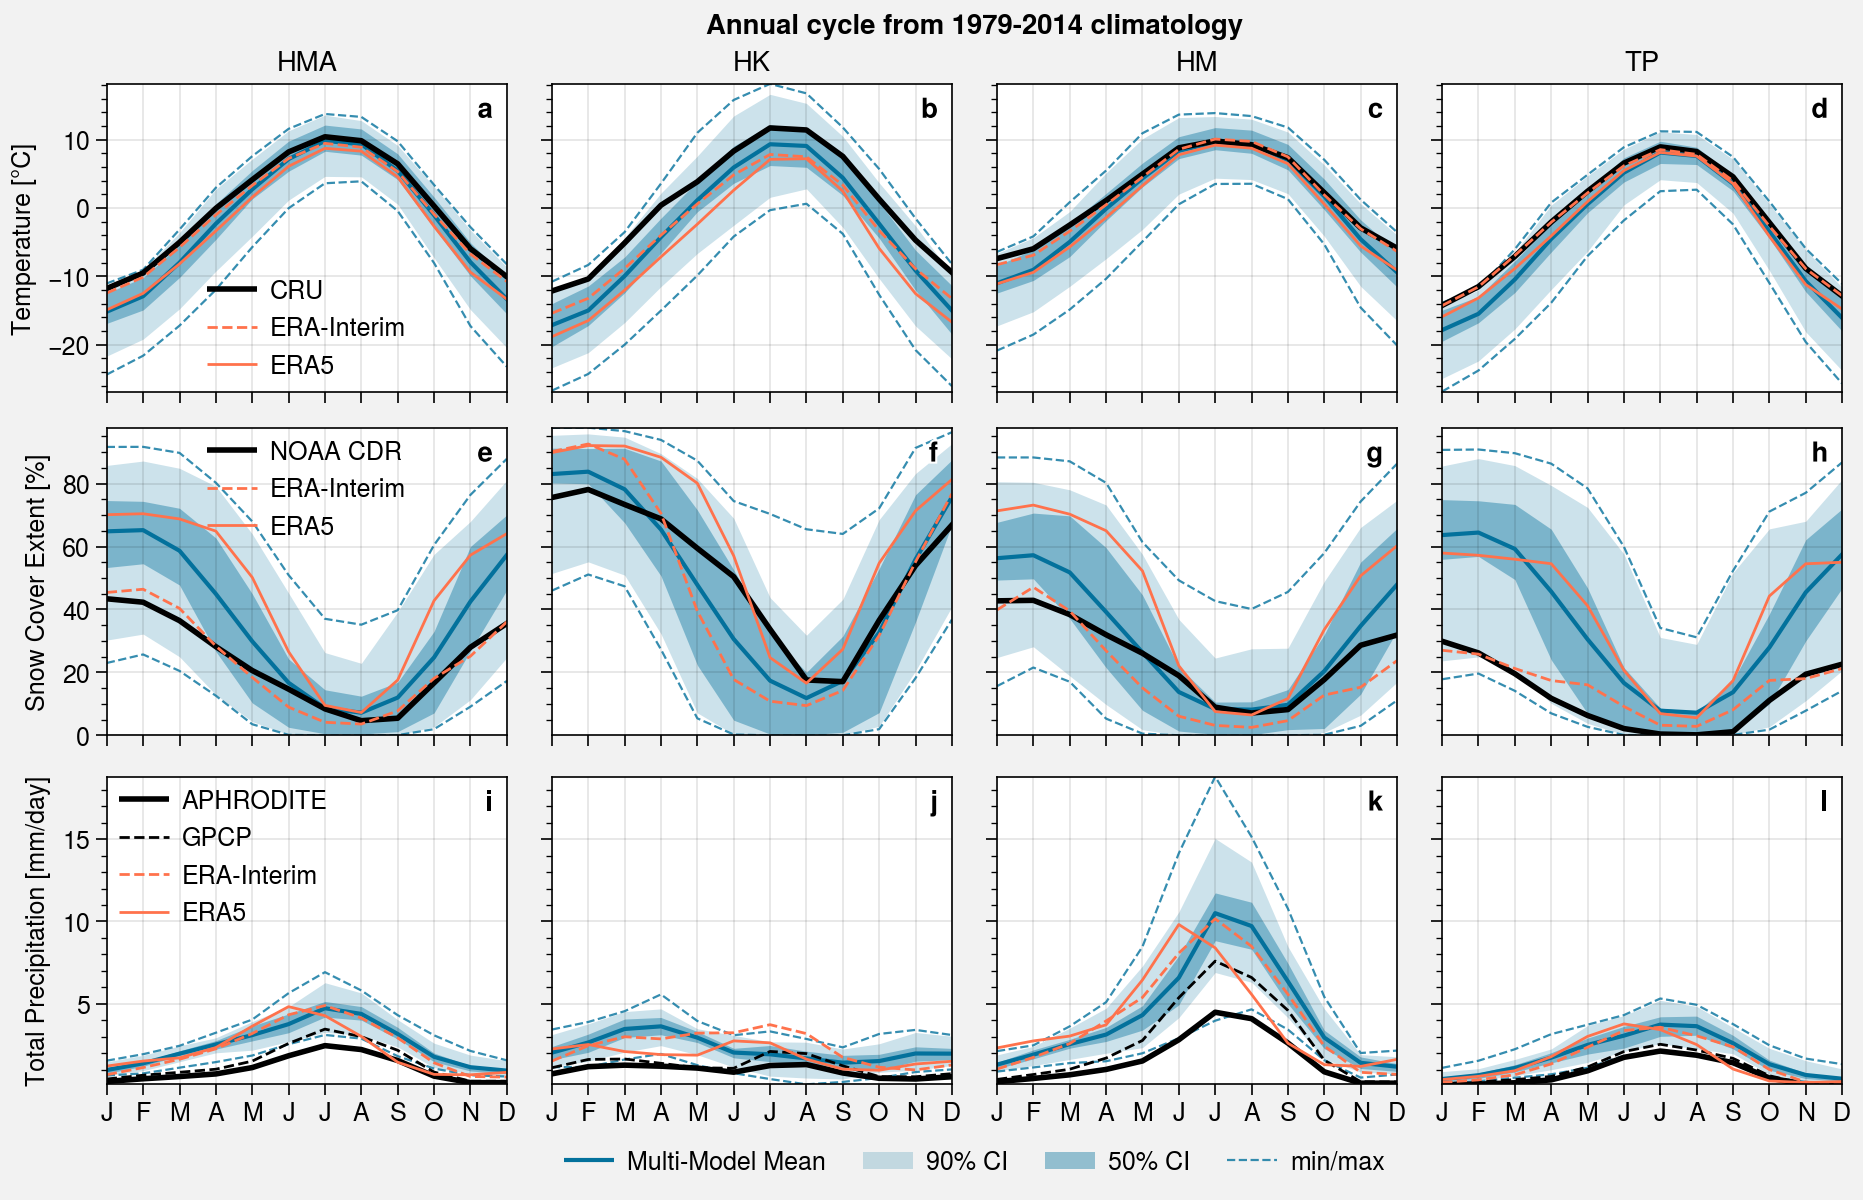

In [30]:
f, axs = plot.subplots(ncols=4, nrows=3, aspect=1.3, sharey=0, axwidth=2)

color_model = 'ocean blue'
color_obs = 'black'
color_era = 'pink orange'

n_ax = 0
for i_var, var in enumerate(list_vars):
    for i in range(len(zones)):
        means = multimodel_ensemble_ac.sel(var=var)[i].mean('model')

        # Compute quantiles  
        shadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.25, 0.75], dim='model')  # dark shading
        fadedata = multimodel_ensemble_ac.sel(var=var)[i].quantile([0.05, 0.95], dim='model')  # light shading

        h1 = axs[n_ax].plot(
            means, 
            shadedata=shadedata, fadedata=fadedata,
            shadelabel='50% CI', fadelabel='90% CI',
            label='Multi-Model Mean', color=color_model, 
        )

        # Add min/max
        h2 = axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].min('model'),
            label='min/max', linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )
        axs[n_ax].plot(
            multimodel_ensemble_ac.sel(var=var)[i].max('model'),
            linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
        )

        # Plot observations
        if var == 'tas':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_tas[i], label='CRU', color=color_obs, linewidth=2)
            h4 = axs[n_ax].plot(obs_ac_regrid_zones_tas_erai[i], label='ERA-Interim', color=color_era, linewidth=1, linestyle='--')
            h5 = axs[n_ax].plot(obs_ac_regrid_zones_tas_era5[i], label='ERA5', color=color_era, linewidth=1)
        elif var == 'snc':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_snc[i], label='NOAA CDR', color=color_obs, linewidth=2)
            h4 = axs[n_ax].plot(obs_ac_regrid_zones_snc_erai[i], label='ERA-Interim', color=color_era, linewidth=1, linestyle='--')
            h5 = axs[n_ax].plot(obs_ac_regrid_zones_snc_era5[i], label='ERA5', color=color_era, linewidth=1)
        elif var == 'pr':
            h3 = axs[n_ax].plot(obs_ac_regrid_zones_pr_aphro[i], label='APHRODITE', color=color_obs, linewidth=2)
            h4 = axs[n_ax].plot(obs_ac_regrid_zones_pr_gpcp[i], label='GPCP', color=color_obs, linewidth=1, linestyle='--')
            h5 = axs[n_ax].plot(obs_ac_regrid_zones_pr_erai[i], label='ERA-Interim', color=color_era, linewidth=1, linestyle='--')
            h6 = axs[n_ax].plot(obs_ac_regrid_zones_pr_era5[i], label='ERA5', color=color_era, linewidth=1)
        
        if i == 0:
            axs[n_ax].format( 
                ylim=(multimodel_ensemble_ac.sel(var=var).min(), multimodel_ensemble_ac.sel(var=var).max()),
                xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
                xlabel=''
            )
        else:
            axs[n_ax].format( 
                ylim=(multimodel_ensemble_ac.sel(var=var).min(), multimodel_ensemble_ac.sel(var=var).max()),
                xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
                xlabel='',
                yticklabels=[]
            )
            
        
        if i_var == 0:
            axs[n_ax].format(title=zones[n_ax])
        
        # Add obs legend and ylabel
        if i == 0:
            if var == 'tas':
                h = [h3, h4, h5]
                loc = 'lc'
            elif var == 'snc':
                h = [h3, h4, h5]
                loc = 'uc'
            elif var == 'pr':
                h = [h3, h4, h5, h6]
                loc = 'ul'
            axs[n_ax].legend(h, loc=loc, frame=False, ncols=1)
            
            labels=['Temperature [°C]', 'Snow Cover Extent [%]', 'Total Precipitation [mm/day]']
            axs[n_ax].format( 
                ylabel = labels[i_var]
            )
        
        n_ax += 1

f.legend([h1[0], h1[1], h1[2], h2], loc='b', frame=False, ncols=4, order='F', center=False)

axs.format(
    suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology',
#     collabels=zones,
    abc=True, abcloc='ur'
)
    
filename = 'fig5_ac_all_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')